# <center>6. Beam Orientation Optimization (BOO) </center>


### This example demonstrates the use of portpy.photon package to create down sampled influence matrix and optimize the plan by selecting optimal beams using beam angle optimization


1. Down sample influence matrix and create a plan using planner beams
2. Create a plan using beam angle optimization (boo)
3. Visualize and compare the plans


### 1) Down sample influence matrix and create a plan using planner beams
 Note: you first need to download the patient database from the link provided in the GitHub page.


In [1]:
import sys
sys.path.append('..')

In [7]:
import portpy.photon as pp
import numpy as np
import os
import cvxpy as cp

In [3]:
# provide data directory and patient id
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id

In [4]:
# Load ct, structure and beams as an object
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# create a influence matrix down sampled beamlets of width and height 10mm and down sampled voxels
voxel_down_sample_factors = [7, 7, 2]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_dbv = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                               beamlet_height_mm=new_beamlet_height_mm,
                                               opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)

plan_planner = pp.Plan(ct, structs, beams, inf_matrix_dbv, clinical_criteria)

opt = pp.Optimization(plan_planner, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_planner = opt.solve(solver='MOSEK', verbose='True')


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 11 02:36:12 PM: Your problem has 1264 variables, 14 constraints, and 0 parameters.
(CVXPY) Jun 11 02:36:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 02:36:12 PM: (If you need to solve this problem multip

(CVXPY) Jun 11 02:36:14 PM: 19  1.7e-05  7.3e-05  3.9e-09  1.00e+00   3.411413901e+02   3.411413913e+02   9.5e-08  1.08  
(CVXPY) Jun 11 02:36:14 PM: 20  6.3e-06  2.7e-05  8.6e-10  1.00e+00   3.411366156e+02   3.411366160e+02   3.5e-08  1.11  
(CVXPY) Jun 11 02:36:14 PM: 21  2.8e-06  1.2e-05  2.5e-10  9.99e-01   3.411348093e+02   3.411348094e+02   1.5e-08  1.14  
(CVXPY) Jun 11 02:36:14 PM: 22  1.1e-06  4.6e-06  6.1e-11  1.00e+00   3.411342328e+02   3.411342329e+02   6.0e-09  1.17  
(CVXPY) Jun 11 02:36:14 PM: 23  7.0e-07  3.0e-06  3.3e-11  9.85e-01   3.411340490e+02   3.411340491e+02   3.9e-09  1.25  
(CVXPY) Jun 11 02:36:14 PM: 24  3.1e-07  8.1e-07  4.5e-12  9.80e-01   3.411337961e+02   3.411337962e+02   1.0e-09  1.28  
(CVXPY) Jun 11 02:36:14 PM: 25  2.6e-07  2.6e-07  8.7e-13  9.86e-01   3.411337451e+02   3.411337451e+02   3.3e-10  1.31  
(CVXPY) Jun 11 02:36:15 PM: 26  9.3e-08  2.4e-07  1.5e-13  9.96e-01   3.411337260e+02   3.411337260e+02   1.2e-10  1.41  
(CVXPY) Jun 11 02:36:15 

### 2) Select optimal beams using beam angle optimization and create benchmark plan
Note: We select 7 optimal beams out of 24 beams due to computational issues arising from Mixed integer programming

In [5]:
# roughly select beam_ids around planner beams
beam_ids = list(np.arange(0, 72, 3))
beams_boo = pp.Beams(data, beam_ids=beam_ids)

# create a influence matrix down sampled beamlets of width and height 10mm
# load influence matrix based upon beams and structure set
inf_matrix_boo = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_boo)

# create a influence matrix down sampled beamlets of width and height 10mm and down sample voxels
voxel_down_sample_factors = [7, 7, 2]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_boo_dbv = inf_matrix_boo.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                                       beamlet_height_mm=new_beamlet_height_mm,
                                                       opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

plan_boo = pp.Plan(ct, structs, beams_boo, inf_matrix_boo_dbv, clinical_criteria)

Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
parsing influence matrix for beam 7
parsing influence matrix for beam 8
parsing influence matrix for beam 9
parsing influence matrix for beam 10
parsing influence matrix for beam 11
parsing influence matrix for beam 12
parsing influence matrix for beam 13
parsing influence matrix for beam 14
parsing influence matrix for beam 15
parsing influence matrix for beam 16
parsing influence matrix for beam 17
parsing influence matrix for beam 18
parsing influence matrix for beam 19
parsing influence matrix for beam 20
parsing influence matrix for beam 21
parsing influence matrix for beam 22
parsing influence matrix for beam 23
creating influence matrix for down sample voxe

### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation

$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x}_b \leq \mathbf{y}_bM  \quad \forall b \in B
$

$
\quad \sum_{b \in B}\mathbf{y} \leq \mu
$

$
\quad \mathbf{x} \geq 0
$

$
\quad \mathbf{y}_b \in \{0,1\}
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, $\mathbf{y}_b$ is binary variable for selecting the beam, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix, $M$ (large number) = 1000, $\mu$ (# of beams selected) = 7.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [8]:
opt = pp.Optimization(plan_boo, opt_params=opt_params)
opt.create_cvxpy_problem()

st = inf_matrix_boo_dbv

# binary variable for selecting beams
b = cp.Variable(len(st.beamlets_dict), boolean=True)
num_beams = 7
x = opt.vars['x']

opt.constraints += [cp.sum(b) <= num_beams]
for i in range(len(st.beamlets_dict)):
    start_beamlet = st.beamlets_dict[i]['start_beamlet_idx']
    end_beamlet = st.beamlets_dict[i]['end_beamlet_idx']
    M = 50  # upper bound on the beamlet intensity
    opt.constraints += [x[start_beamlet:end_beamlet] <= b[i] * M]
sol_boo = opt.solve(solver='MOSEK', verbose='True')

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 11 02:40:23 PM: Your problem has 1696 variables, 49 constraints, and 0 parameters.
(CVXPY) Jun 11 02:40:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 02:40:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 11 02:40:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 02:40:23 P

(CVXPY) Jun 11 05:52:59 PM: Initial feasible solution objective: Undefined
(CVXPY) Jun 11 05:52:59 PM: Construct solution objective       : Not employed
(CVXPY) Jun 11 05:53:00 PM: User objective cut value           : Not employed
(CVXPY) Jun 11 05:53:00 PM: Number of cuts generated           : 47
(CVXPY) Jun 11 05:53:00 PM:   Number of CMIR cuts              : 47
(CVXPY) Jun 11 05:53:00 PM: Number of branches                 : 3285
(CVXPY) Jun 11 05:53:00 PM: Number of relaxations solved       : 3292
(CVXPY) Jun 11 05:53:00 PM: Number of interior point iterations: 177282
(CVXPY) Jun 11 05:53:00 PM: Number of simplex iterations       : 0
(CVXPY) Jun 11 05:53:00 PM: Time spend presolving the root     : 11.58
(CVXPY) Jun 11 05:53:00 PM: Time spend optimizing the root     : 9.72
(CVXPY) Jun 11 05:53:00 PM: Mixed integer optimizer terminated. Time: 11546.56
(CVXPY) Jun 11 05:53:00 PM: 
(CVXPY) Jun 11 05:53:00 PM: Optimizer terminated. Time: 11546.99
(CVXPY) Jun 11 05:53:00 PM: 
(CVXPY) Jun

### 3) Visualize and compare the plans

In [9]:
# Identifying bao and planner gantry angles
boo_gantry_angles = (np.asarray(plan_boo.beams.beams_dict['gantry_angle']) + 1) * (b.value > 0)
boo_gantry_angles = boo_gantry_angles[boo_gantry_angles > 0] - 1  # add and subtract 1 to check for 0 degree angle
print('BOO gantry angles: {}'.format(boo_gantry_angles))
planner_gantry_angles = plan_planner.beams.beams_dict['gantry_angle']
print('Planner gantry angles: {}'.format(planner_gantry_angles))

BOO gantry angles: [ 15  60  90 120 225 330 345]
Planner gantry angles: [0, 30, 60, 90, 120, 150, 180]


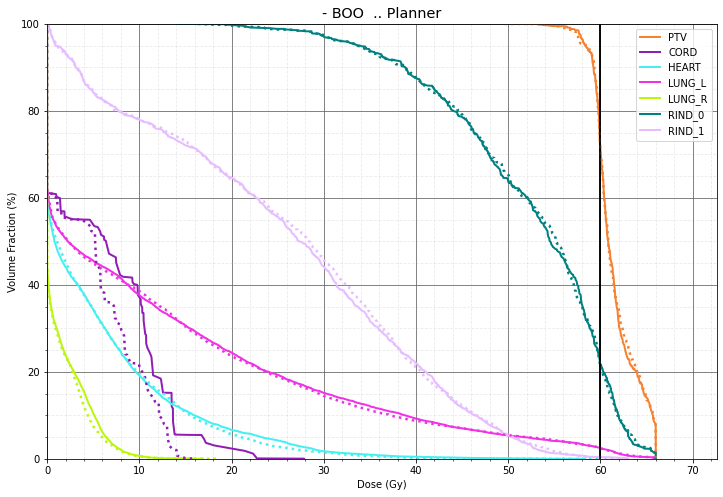

In [11]:
# plot dvh dvh for both the cases
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L', 'LUNG_R', 'RIND_0', 'RIND_1']
ax = pp.Visualization.plot_dvh(plan_boo, sol=sol_boo, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_planner, sol=sol_planner, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- BOO  .. Planner')
plt.show()
